In [1]:
# Import libraries
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Concat all data
train = pd.read_csv('split-data/train.csv')
validate = pd.read_csv('split-data/validate.csv')
test = pd.read_csv('split-data/test.csv')
df = pd.concat([train, validate, test], ignore_index=True)

In [3]:
def tokenize_and_stem(text):
    """Tokenize and stem the text"""
    tokenizer = RegexpTokenizer(r'\w+')
    snow_stemmer = SnowballStemmer(language='english')
    words = tokenizer.tokenize(text)
    stemmed_words = []
    for w in words:
        if len(w) < 2:
            continue
        stemmed_words.append(snow_stemmer.stem(w))
    return stemmed_words

In [4]:
def transform_df(df):
    """Pipeline to implement vectorization and tf-idf transformation"""
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(analyzer=tokenize_and_stem)),
        ('tfidf', TfidfTransformer())
    ])
    corpus = df.text
    pipeline.fit(corpus)
    corpus_tfidf = pipeline.transform(corpus)

    print(f'Shape of transformed matrix: {corpus_tfidf.shape}')
    print(f'Number of non-zero: {corpus_tfidf.nnz}')
    print(f'Sparsity: {round(100.0*corpus_tfidf.nnz/(corpus_tfidf.shape[0]*corpus_tfidf.shape[1]),3)}%\n')

    df_transform = pd.concat([df, pd.DataFrame(corpus_tfidf.toarray())], axis=1)
    df_transform.drop('text', axis=1, inplace=True)

    return df_transform

In [5]:
# Transform and split the data
df_transform = transform_df(df)
train, test = train_test_split(df_transform, train_size=0.8,stratify=df_transform.label)

Shape of transformed matrix: (5120, 6632)
Number of non-zero: 67057
Sparsity: 0.197%



In [6]:
# Reset index and make column names string
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)

In [7]:
# Split the data into X and y
X_train = train.drop('label', axis=1)
y_train = train.label

X_test = test.drop('label', axis=1)
y_test = test.label

In [8]:
# Initiate mlflow tracking
mlflow.set_tracking_uri("mlflow")
mlflow.set_experiment("Model Version Control")

2025/02/17 14:07:36 INFO mlflow.tracking.fluent: Experiment with name 'Model Version Control' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/CMI/CMI_Git/AppliedML/Assignment 2/mlflow/798228184358758638', creation_time=1739781456621, experiment_id='798228184358758638', last_update_time=1739781456621, lifecycle_stage='active', name='Model Version Control', tags={}>

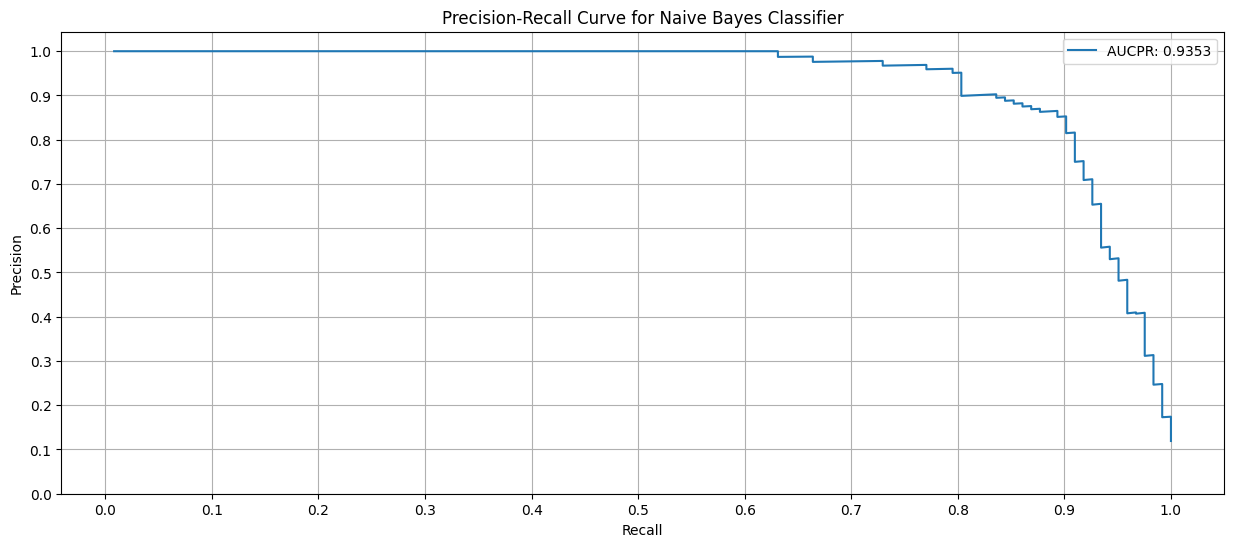

2025/02/17 14:07:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Naive Bayes Classifier'.
Created version '1' of model 'Naive Bayes Classifier'.


Model: Naive Bayes Classifier, AUCPR: 0.9353


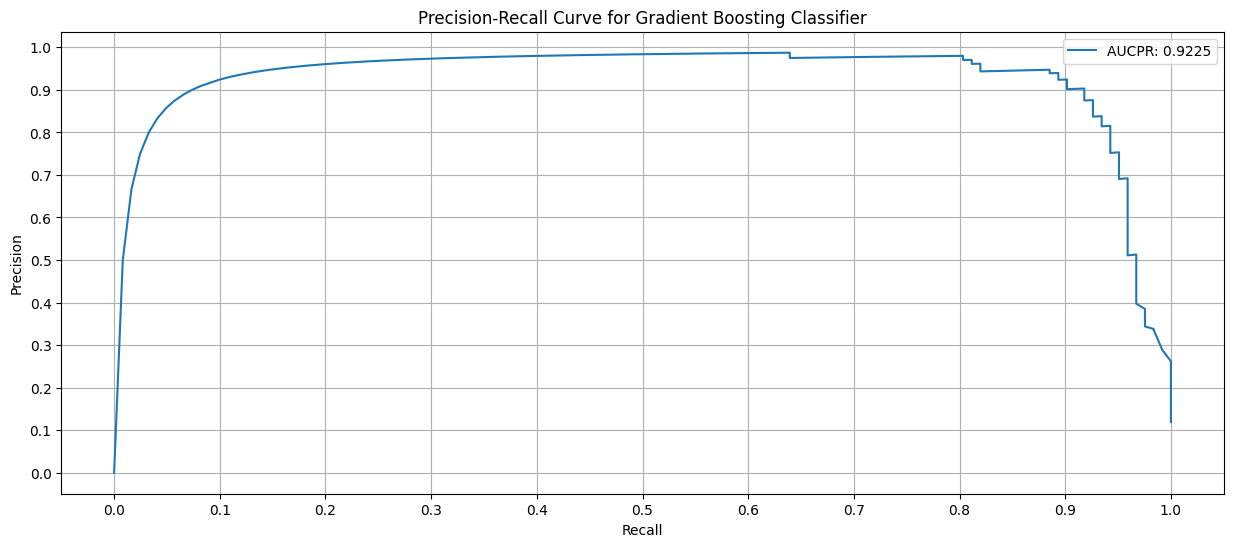

2025/02/17 14:08:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Gradient Boosting Classifier'.
Created version '1' of model 'Gradient Boosting Classifier'.


Model: Gradient Boosting Classifier, AUCPR: 0.9225


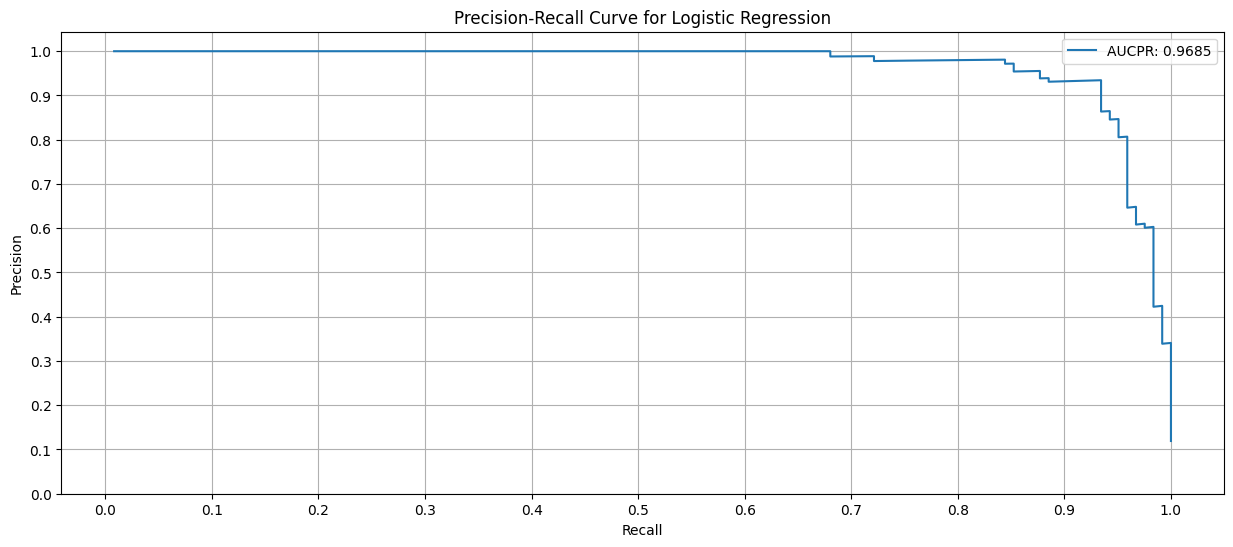

2025/02/17 14:08:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Logistic Regression, AUCPR: 0.9685


Successfully registered model 'Logistic Regression'.
Created version '1' of model 'Logistic Regression'.


In [9]:
# Log the metrics and register the models
models = {
    "Naive Bayes Classifier": MultinomialNB(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
}

# Train and log each model
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        prt = zip(thresholds, precision, recall)
        prt = sorted(prt, key=lambda x: x[0], reverse=False)
        aucpr = round(average_precision_score(y_test, y_pred),4)

        plt.figure(figsize=(15, 6))
        plt.plot([x[2] for x in prt], [x[1] for x in prt])
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve for {name}")
        plt.legend([f"AUCPR: {aucpr}"])
        plt.grid(True)
        plt.show()

        # Log model, metrics
        mlflow.log_param("model", name)
        mlflow.log_metric("aucpr", aucpr)
        mlflow.sklearn.log_model(model, name)

        # Register the model
        model_uri = f"models:/{name}/1"
        mlflow.register_model(f"runs:/{mlflow.active_run().info.run_id}/{name}", name)
        print(f"Model: {name}, AUCPR: {aucpr}")

In [10]:
# Check out the model and print AUCPR metric
client = mlflow.tracking.MlflowClient()
experiment = mlflow.get_experiment_by_name("Model Version Control")
runs = client.search_runs(experiment.experiment_id)

print("Model Performance (AUCPR):")
for run in runs:
    model_name = run.data.params["model"]
    ap = run.data.metrics["aucpr"]
    print(f"{model_name}: {ap}")

Model Performance (AUCPR):
Logistic Regression: 0.9685
Gradient Boosting Classifier: 0.9225
Naive Bayes Classifier: 0.9353
